In [ ]:
!pip install --quiet kaggle scikit-image

In [ ]:
from google.colab import files
# Upload your kaggle.json (get this from Kaggle → “My Account” → “API” → “Create New Token”)
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"soumadityadeb","key":"2cc778f3e990d4f299998b8e365aabce"}'}

In [ ]:
# Set permissions and move it into place
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the “salader/dogs-vs-cats” dataset and unzip
!kaggle datasets download -d salader/dogs-vs-cats
!unzip -q dogs-vs-cats.zip -d ./data

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ./data/dogs_vs_cats/test/cats/cat.10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Point DATA_DIR at the train folder
DATA_DIR = './data/train'   # contains subfolders 'cats/' and 'dogs/'

In [ ]:
# 1. Imports

import os, io, cv2, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection   import train_test_split, GridSearchCV
from sklearn.preprocessing     import StandardScaler
from sklearn.svm               import LinearSVC
from sklearn.calibration       import CalibratedClassifierCV
from sklearn.metrics           import classification_report, confusion_matrix, accuracy_score
from skimage.feature           import hog
import joblib

import ipywidgets as widgets
from IPython.display import display
from PIL import Image
from scipy.special import expit

In [ ]:
# 2: Load & Preprocess Functions

CATEGORIES = ['cats','dogs']
IMG_SIZE   = 64

def load_data(data_dir):
    images, labels = [], []
    for idx, lbl in enumerate(CATEGORIES):
        folder = os.path.join(data_dir, lbl)
        for fname in os.listdir(folder):
            path = os.path.join(folder, fname)
            img = cv2.imread(path)
            if img is None: continue
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(gray.flatten())
            labels.append(idx)
    return np.array(images), np.array(labels)

def compute_hog(flat_images):
    feats = []
    for flat in flat_images:
        img = flat.reshape(IMG_SIZE,IMG_SIZE)
        h = hog(img,
                pixels_per_cell=(8,8),
                cells_per_block=(2,2),
                feature_vector=True)
        feats.append(h)
    return np.array(feats)


In [ ]:
# 3: Load data, split, scale & check balance

X, y = load_data(DATA_DIR)
print(f"Loaded {X.shape[0]} samples.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train class counts:", dict(zip(CATEGORIES, np.bincount(y_train))))
print("Test class counts: ", dict(zip(CATEGORIES, np.bincount(y_test))))

# Scale raw pixels then extract HOG
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_feat = compute_hog(X_train_scaled)
X_test_feat  = compute_hog(X_test_scaled)

Loaded 20000 samples.
Train class counts: {'cats': np.int64(8000), 'dogs': np.int64(8000)}
Test class counts:  {'cats': np.int64(2000), 'dogs': np.int64(2000)}


In [ ]:
# 4: Hyperparameter tuning + Train & Calibrate SVM

# 1) GridSearch for best C on LinearSVC
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(
    LinearSVC(max_iter=5000, tol=1e-4),
    param_grid, cv=3, n_jobs=-1
)
grid.fit(X_train_feat, y_train)
print("Best C:", grid.best_params_)

# 2) Wrap best LinearSVC in CalibratedClassifierCV
base_svc = grid.best_estimator_
svm_model = CalibratedClassifierCV(base_svc, cv=3)
svm_model.fit(X_train_feat, y_train)

# 3) Save artifacts
os.makedirs('/content/models', exist_ok=True)
joblib.dump(svm_model, '/content/models/svm_cat_dog_calibrated.pkl')
joblib.dump(scaler,    '/content/models/scaler.pkl')

Best C: {'C': 0.01}


['/content/models/scaler.pkl']

              precision    recall  f1-score   support

        cats       0.73      0.73      0.73      2000
        dogs       0.73      0.73      0.73      2000

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



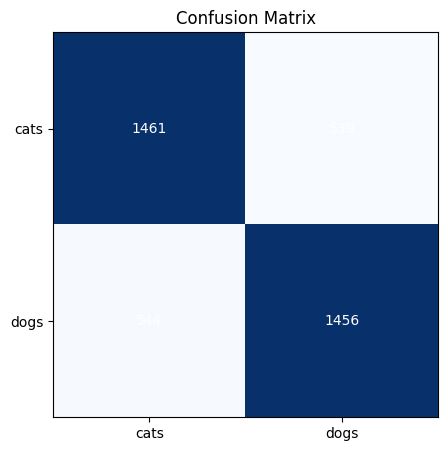

In [ ]:
# 5: Evaluate on Test Set

y_pred = svm_model.predict(X_test_feat)
print(classification_report(y_test, y_pred, target_names=CATEGORIES))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks([0,1], CATEGORIES)
plt.yticks([0,1], CATEGORIES)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='white')
plt.show()

In [ ]:
# 6: Reload for Widget
svm    = joblib.load('/content/models/svm_cat_dog_calibrated.pkl')
scaler = joblib.load('/content/models/scaler.pkl')

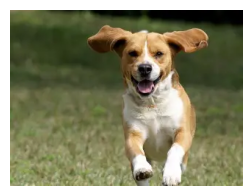

In [ ]:
# 7: FileUpload + Inline Prediction Widget
upload = widgets.FileUpload(
    accept='image/*', multiple=False,
    description='Upload Cat/Dog Image'
)
out = widgets.Output()

def on_upload_change(change):
    out.clear_output()
    if not upload.value:
        return

    # load & display
    key     = next(iter(upload.value))
    content = upload.value[key]['content']
    img     = Image.open(io.BytesIO(content)).convert('RGB')
    with out:
        plt.figure(figsize=(3,3))
        plt.imshow(img); plt.axis('off')

    # preprocess → HOG features
    gray = img.resize((IMG_SIZE,IMG_SIZE)).convert('L')
    arr  = np.array(gray).flatten().reshape(1,-1)
    arr_scaled = scaler.transform(arr)
    feat = compute_hog(arr_scaled)

    # predict with calibrated SVM
    probs = svm.predict_proba(feat)[0]
    idx   = np.argmax(probs)
    cls   = CATEGORIES[idx].capitalize()
    conf  = probs[idx] * 100

    with out:
        print(f"Prediction: {cls} ({conf:.2f}% confidence)")

upload.observe(on_upload_change, names='value')
display(widgets.VBox([upload, out]))

In [ ]:
# 8: Install & import Gradio, load your model, and launch the interface

!pip install --quiet gradio

import gradio as gr

# (re)load your saved artifacts
svm    = joblib.load('/content/models/svm_cat_dog_calibrated.pkl')
scaler = joblib.load('/content/models/scaler.pkl')

CATEGORIES = ['cats','dogs']
IMG_SIZE   = 64

def compute_hog(flat_images):
    feats = []
    for flat in flat_images:
        img = flat.reshape(IMG_SIZE, IMG_SIZE)
        feats.append(hog(img,
                         pixels_per_cell=(8,8),
                         cells_per_block=(2,2),
                         feature_vector=True))
    return np.array(feats)

def predict_fn(input_img: Image.Image):
    img = input_img.convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    gray = img.convert('L')
    arr  = np.array(gray).flatten().reshape(1, -1)
    arr_scaled = scaler.transform(arr)
    feat       = compute_hog(arr_scaled)
    probs      = svm.predict_proba(feat)[0]

    top_idx = np.argmax(probs)
    top_label = CATEGORIES[top_idx].capitalize()
    confidence = probs[top_idx] * 100
    label = f"{top_label} ({confidence:.2f}%)"

    label_probs = {
        CATEGORIES[0].capitalize(): round(probs[0] * 100, 2),
        CATEGORIES[1].capitalize(): round(probs[1] * 100, 2)
    }

    return label, label_probs

demo = gr.Interface(
    fn=predict_fn,
    inputs=gr.Image(type="pil", label="Upload Cat or Dog"),
    outputs=[gr.Label(num_top_classes=2, label="Prediction"),
             gr.JSON(label="All Class Confidences")],
    title="Cats vs Dogs Classifier",
    description="Upload an image and see the model’s prediction & confidence.",
)


demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ae1415675f6bf0ff2b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
